<a href="https://colab.research.google.com/github/keith-leung/cis667/blob/master/TTTNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
"""
TODO:
Compare batched and non batched training times
Compare with and without data augmentation
"""

'\nTODO:\nCompare batched and non batched training times\nCompare with and without data augmentation\n'

In [ ]:
import numpy as np
import matplotlib.pyplot as pt
import torch as tr

In [ ]:
# Domain API for tic tac toe, similar to the minimax lecture
class TicTacToeState(object):

    def __init__(self, board):
        self.board = board.copy()
    def __str__(self):
        return "\n".join(["".join(row) for row in self.board])

    def is_leaf(self):
        if self.score_for_max_player() != 0: return True
        return (self.board == "_").sum() == 0

    def score_for_max_player(self):
        # max player is X
        for player, score in zip("XO", [+1, -1]):
            if (self.board == player).all(axis=0).any(): return score
            if (self.board == player).all(axis=1).any(): return score
            if (np.diag(self.board) == player).all(): return score
            if (np.diag(np.rot90(self.board)) == player).all(): return score
        return 0

    def is_max_players_turn(self):
        return (self.board == "O").sum() == (self.board == "X").sum()
    def is_min_players_turn(self):
        return not self.is_max_players_turn()

    def valid_actions(self):
        return list(zip(*np.nonzero(self.board == "_")))

    def perform(self, action):
        player = "X" if self.is_max_players_turn() else "O"
        row, col = action
        new_state = TicTacToeState(self.board)
        new_state.board[row, col] = player
        return new_state

def initial_state(size):
    board = np.empty((size, size), dtype=str)
    board[:] = "_"
    return TicTacToeState(board)

if __name__ == "__main__":
    
    state = initial_state(size=5)
    print(state)
    while True:
        if state.is_leaf(): break
        actions = state.valid_actions()
        print(actions)
        if len(actions) == 0: break
        state = state.perform(actions[0])
        print(state)
    print("max score, is over:")
    print(state.score_for_max_player())
    print(state.is_leaf())


_____
_____
_____
_____
_____
[(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (1, 0), (1, 1), (1, 2), (1, 3), (1, 4), (2, 0), (2, 1), (2, 2), (2, 3), (2, 4), (3, 0), (3, 1), (3, 2), (3, 3), (3, 4), (4, 0), (4, 1), (4, 2), (4, 3), (4, 4)]
X____
_____
_____
_____
_____
[(0, 1), (0, 2), (0, 3), (0, 4), (1, 0), (1, 1), (1, 2), (1, 3), (1, 4), (2, 0), (2, 1), (2, 2), (2, 3), (2, 4), (3, 0), (3, 1), (3, 2), (3, 3), (3, 4), (4, 0), (4, 1), (4, 2), (4, 3), (4, 4)]
XO___
_____
_____
_____
_____
[(0, 2), (0, 3), (0, 4), (1, 0), (1, 1), (1, 2), (1, 3), (1, 4), (2, 0), (2, 1), (2, 2), (2, 3), (2, 4), (3, 0), (3, 1), (3, 2), (3, 3), (3, 4), (4, 0), (4, 1), (4, 2), (4, 3), (4, 4)]
XOX__
_____
_____
_____
_____
[(0, 3), (0, 4), (1, 0), (1, 1), (1, 2), (1, 3), (1, 4), (2, 0), (2, 1), (2, 2), (2, 3), (2, 4), (3, 0), (3, 1), (3, 2), (3, 3), (3, 4), (4, 0), (4, 1), (4, 2), (4, 3), (4, 4)]
XOXO_
_____
_____
_____
_____
[(0, 4), (1, 0), (1, 1), (1, 2), (1, 3), (1, 4), (2, 0), (2, 1), (2, 2), (2, 3), (2, 4), (3, 0

In [ ]:
# Code to generate training data
# Each training example is an intermediate game state, paired with its minimax value

# The minimax algorithm
def minimax(state):
    if state.is_leaf():
        return state.score_for_max_player()
    else:
        child_utilities = [
            minimax(state.perform(action))
            for action in state.valid_actions()]
        if state.is_max_players_turn(): return max(child_utilities)
        if state.is_min_players_turn(): return min(child_utilities)

# Used to get a random state somewhere in the game tree for a training example
# Performs random actions for the given number of turns (depth parameter)
def random_state(depth=0, size=3):
    state = initial_state(size)
    for d in range(depth):
        actions = state.valid_actions()
        if len(actions) == 0: break
        action = actions[np.random.randint(len(actions))]
        state = state.perform(action)
    return state

# Used to generate a training data set
# Samples random states at a given depth and then calculates their minimax value
def generate(num_examples, depth, size):
    examples = []
    for n in range(num_examples):
        state = random_state(depth, size)
        utility = minimax(state)
        examples.append((state, utility))
    return examples

# Augment data with rotations and reflections
def augment(examples):
    augmented = []
    for state, utility in examples:
        for k in range(4):
            rot = np.rot90(state.board, k)
            augmented.append((TicTacToeState(rot), utility))
            augmented.append((TicTacToeState(rot[:,::-1]), utility))
    return augmented

# Used to convert a game state to a tensor encoding suitable for NN input
# Uses one-hot encoding at each grid position
def encode(state):
    # encoding[0,:,:] == 1 where there are "_"s, 0 elsewhere
    # encoding[1,:,:] == 1 where there are "O"s, 0 elsewhere
    # encoding[2,:,:] == 1 where there are "X"s, 0 elsewhere
    symbols = np.array(["_","O","X"]).reshape(-1,1,1)
    onehot = (symbols == state.board).astype(np.float32)
    return tr.tensor(onehot)

# Run some sanity checks to make sure generation and encoding are working
if __name__ == "__main__":

    size = 4

    examples = generate(num_examples=5, depth=10, size=size)
    for n, (state, utility) in enumerate(examples):
        print("example %d:" % n)
        print(state)
        print("utility = %d" % utility)

    print("Encoding of last example state:")
    encoding = encode(state)
    print(encoding)

    # quick test for encode
    print("")
    print("Encoding of initial state:")
    encoding = encode(initial_state(size))
    print(encoding)
    assert(type(encoding) == tr.Tensor)
    expected = tr.zeros((3,size,size))
    expected[0,:,:] = 1
    assert((encoding == expected).all())
    
    print("If you see this line, initial state was encoded correctly")



example 0:
_OXX
_OX_
__XO
_OXO
utility = 1
example 1:
XO__
_OOO
X_OX
X_X_
utility = 1
example 2:
_OX_
_XO_
__OO
XOXX
utility = 0
example 3:
O__O
XXX_
OO__
OX_X
utility = 1
example 4:
OOX_
_XX_
OXO_
__XO
utility = 0
Encoding of last example state:
tensor([[[0., 0., 0., 1.],
         [1., 0., 0., 1.],
         [0., 0., 0., 1.],
         [1., 1., 0., 0.]],

        [[1., 1., 0., 0.],
         [0., 0., 0., 0.],
         [1., 0., 1., 0.],
         [0., 0., 0., 1.]],

        [[0., 0., 1., 0.],
         [0., 1., 1., 0.],
         [0., 1., 0., 0.],
         [0., 0., 1., 0.]]])

Encoding of initial state:
tensor([[[1., 1., 1., 1.],
         [1., 1., 1., 1.],
         [1., 1., 1., 1.],
         [1., 1., 1., 1.]],

        [[0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.]],

        [[0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.]]])
If you see this line, initial state was encoded correctly


In [ ]:
# Generate a lot of training/testing data
training_examples = generate(num_examples = 100, depth=10, size=4)
testing_examples = generate(num_examples = 50, depth=10, size=4)

# augment training data
print(len(training_examples))
training_examples = augment(training_examples)
print(len(training_examples))

100
800


In [ ]:
# Baseline testing error: always predict 0 for minimax result
_, utilities = zip(*testing_examples)
baseline_error =sum((u-0)**2 for u in utilities) / len(utilities)
print(baseline_error)

0.48


In [ ]:
# Defines a network with two fully-connected layers and tanh activation functions
class LinNet(tr.nn.Module):
    def __init__(self, size, hid_features):
        super(LinNet, self).__init__()
        self.to_hidden = tr.nn.Linear(3*size**2, hid_features)
        self.to_output = tr.nn.Linear(hid_features, 1)
    def forward(self, x):
        h = tr.relu(self.to_hidden(x.reshape(x.shape[0],-1)))
        y = tr.tanh(self.to_output(h))
        return y

class ConvNet(tr.nn.Module):
    def __init__(self, size, hid_features):
        super(ConvNet, self).__init__()
        self.to_hidden = tr.nn.Conv2d(3, hid_features, 2)
        self.to_output = tr.nn.Linear(hid_features*(size-1)**2, 1)
    def forward(self, x):
        h = tr.relu(self.to_hidden(x))
        y = tr.tanh(self.to_output(h.reshape(x.shape[0],-1)))
        return y

for Net in (LinNet, ConvNet):
    net = Net(size=4, hid_features=8)
    print(net)
    print(net(tr.zeros(1,3,4,4)))


LinNet(
  (to_hidden): Linear(in_features=48, out_features=8, bias=True)
  (to_output): Linear(in_features=8, out_features=1, bias=True)
)
tensor([[-0.2739]], grad_fn=<TanhBackward0>)
ConvNet(
  (to_hidden): Conv2d(3, 8, kernel_size=(2, 2), stride=(1, 1))
  (to_output): Linear(in_features=72, out_features=1, bias=True)
)
tensor([[-0.0013]], grad_fn=<TanhBackward0>)


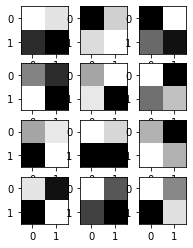

In [ ]:
def cnn_viz(net):
    numrows = net.to_hidden.weight.shape[0] # out channels
    numcols = net.to_hidden.weight.shape[1] # in channels
    pt.figure(figsize=(numcols, numrows))

    sp = 0
    for r in range(numrows):
        for c in range(numcols):
            sp += 1
            pt.subplot(numrows, numcols, sp)
            pt.imshow(net.to_hidden.weight[r,c].detach().numpy(), cmap="gray")
    pt.show()

cnn_viz(ConvNet(4, hid_features=4))

In [ ]:
# Calculates the error on one training example
def example_error(net, example):
    state, utility = example
    x = encode(state).unsqueeze(0)
    y = net(x)
    e = (y - utility)**2
    return e

# Calculates the error on a batch of training examples
def batch_error(net, batch):
    states, utilities = batch
    u = utilities.reshape(-1,1).float()
    y = net(states)
    e = tr.sum((y - u)**2) / utilities.shape[0]
    return e

# Trains the network on some generated data
if __name__ == "__main__":

    # whether to loop over individual training examples or batch them
    batched = True

    # Make the network and optimizer
    # net = LinNet(size=4, hid_features=4)
    # optimizer = tr.optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

    net = ConvNet(size=4, hid_features=4)
    optimizer = tr.optim.SGD(net.parameters(), lr=0.00001, momentum=0.9)

    # Convert the states and their minimax utilities to tensors
    states, utilities = zip(*training_examples)
    training_batch = tr.stack(tuple(map(encode, states))), tr.tensor(utilities)

    states, utilities = zip(*testing_examples)
    testing_batch = tr.stack(tuple(map(encode, states))), tr.tensor(utilities)

    # Run the gradient descent iterations
    curves = [], []
    for epoch in range(50000):
    
        # zero out the gradients for the next backward pass
        optimizer.zero_grad()

        # loop version (slow)
        if not batched:
 
            training_error, testing_error = 0, 0

            for n, example in enumerate(training_examples):
                e = example_error(net, example)
                e.backward()
                training_error += e.item()
            training_error /= len(training_examples)

            with tr.no_grad(): # less computationally expensive
                for n, example in enumerate(testing_examples):
                    e = example_error(net, example)
                    testing_error += e.item()
                testing_error /= len(testing_examples)

        # batch version (fast)
        if batched:
            e = batch_error(net, training_batch)
            e.backward()
            training_error = e.item()

            with tr.no_grad():
                e = batch_error(net, testing_batch)
                testing_error = e.item()

        # take the next optimization step
        optimizer.step()    
        
        # print/save training progress
        if epoch % 1000 == 0:
            print("%d: %f, %f" % (epoch, training_error, testing_error))
        curves[0].append(training_error)
        curves[1].append(testing_error)


0: 0.608205, 0.769377
1000: 0.415710, 0.538543
2000: 0.330072, 0.428285
3000: 0.292232, 0.375735
4000: 0.275493, 0.350167
5000: 0.267955, 0.337431
6000: 0.264374, 0.330928
7000: 0.262466, 0.327451
8000: 0.261278, 0.325497
9000: 0.260406, 0.324362
10000: 0.259684, 0.323681
11000: 0.259041, 0.323266
12000: 0.258443, 0.323017
13000: 0.257877, 0.322873
14000: 0.257336, 0.322794
15000: 0.256812, 0.322744
16000: 0.256308, 0.322724
17000: 0.255822, 0.322720
18000: 0.255356, 0.322719
19000: 0.254906, 0.322721
20000: 0.254471, 0.322730
21000: 0.254050, 0.322747
22000: 0.253641, 0.322769
23000: 0.253243, 0.322794
24000: 0.252856, 0.322823
25000: 0.252480, 0.322856
26000: 0.252116, 0.322890
27000: 0.251762, 0.322930
28000: 0.251417, 0.322973
29000: 0.251082, 0.323017
30000: 0.250747, 0.323084
31000: 0.250417, 0.323141
32000: 0.250095, 0.323193
33000: 0.249781, 0.323243
34000: 0.249476, 0.323289
35000: 0.249183, 0.323306
36000: 0.248898, 0.323322
37000: 0.248621, 0.323347
38000: 0.248349, 0.323377

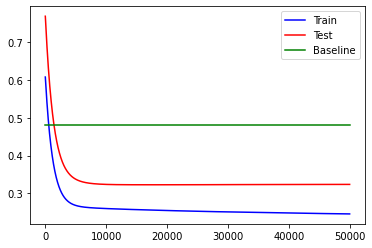

In [ ]:
# visualize learning curves on train/test data
pt.plot(curves[0], 'b-')
pt.plot(curves[1], 'r-')
pt.plot([0, len(curves[1])], [baseline_error, baseline_error], 'g-')
pt.plot()
pt.legend(["Train","Test","Baseline"])
pt.show()


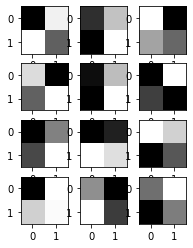

In [ ]:
cnn_viz(net)

In [ ]:
# Compare two AIs against each-other using depth-limited minimax
# Returns the best action and its child utility

def dl_minimax(state, max_depth, eval_fn):
    if state.is_leaf():
        return 0, state.score_for_max_player()
    elif max_depth == 0:
        return 0, eval_fn(state)
    else:
        child_utilities = [
            dl_minimax(state.perform(action), max_depth-1, eval_fn)[1]
            for action in state.valid_actions()]

        if state.is_max_players_turn(): a = np.argmax(child_utilities)
        if state.is_min_players_turn(): a = np.argmin(child_utilities)

        return a, child_utilities[a]

# Baseline AI uses a very simple evaluation function that always returns 0 for non-leaf nodes
simple_eval = lambda state: 0

# The other AI uses the NN for its eval_fn
def nn_eval(state):
    with tr.no_grad():
        utility = net(encode(state).unsqueeze(0))
    return utility

In [ ]:
# Play the two AI's against each other

state = initial_state(size=4)
print(state)
while not state.is_leaf():

    if state.is_max_players_turn():
        # for action in state.valid_actions():
        #     child = state.perform(action)
        #     nn_eval(child)
        # np.argmax(...)

        a, _ = dl_minimax(state, 4, nn_eval)
    
    else:

        a, _ = dl_minimax(state, 4, simple_eval) # baseline eval
        #a = np.random.choice(len(state.valid_actions())) # baseline uniform

    action = state.valid_actions()[a]
    print(action)

    state = state.perform(action)
    print(state)

print("Final score:")
print(state.score_for_max_player())

____
____
____
____
(0, 0)
X___
____
____
____
(0, 1)
XO__
____
____
____
(2, 2)
XO__
____
__X_
____
(0, 2)
XOO_
____
__X_
____
(3, 3)
XOO_
____
__X_
___X
(1, 1)
XOO_
_O__
__X_
___X
(2, 1)
XOO_
_O__
_XX_
___X
(0, 3)
XOOO
_O__
_XX_
___X
(2, 0)
XOOO
_O__
XXX_
___X
(2, 3)
XOOO
_O__
XXXO
___X
(3, 0)
XOOO
_O__
XXXO
X__X
(1, 0)
XOOO
OO__
XXXO
X__X
(1, 2)
XOOO
OOX_
XXXO
X__X
(1, 3)
XOOO
OOXO
XXXO
X__X
(3, 1)
XOOO
OOXO
XXXO
XX_X
(3, 2)
XOOO
OOXO
XXXO
XXOX
Final score:
0
